In [2]:
# ============================================================================
# NOTEBOOK 2: COPULA COMPARISON FOR DRAKE EQUATION
# ============================================================================
#
# This notebook explores different copula models to capture dependencies 
# between Drake Equation parameters.
#
# Copulas allow us to model the dependency structure separately from the 
# marginal distributions.

# ============================================================================
# CELL 1: IMPORTS
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kendalltau, spearmanr

from drake.Parameters import BASELINE_PARAMS
from drake.monte_carlo import run_monte_carlo

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports successful")

✓ Imports successful


In [18]:
# ============================================================================
# CELL 2: GENERATE BASELINE DATA (FIXED)
# ============================================================================

# Generate baseline Monte Carlo results
n_sims = 5000
mc_results = run_monte_carlo(BASELINE_PARAMS, n_simulations=n_sims)

# Extract data from the packed structure (same as notebook 1)
if isinstance(mc_results, pd.DataFrame):
    raw_results = mc_results['raw'].iloc[0] if hasattr(mc_results['raw'], 'iloc') else mc_results['raw'][0]
    N_values = mc_results['N'].iloc[0] if hasattr(mc_results['N'], 'iloc') else mc_results['N'][0]
elif isinstance(mc_results, dict):
    raw_results = mc_results['raw']
    N_values = mc_results['N']
else:
    raise ValueError(f"Unexpected mc_results type: {type(mc_results)}")

# Convert to DataFrame
df = pd.DataFrame(raw_results)

# Ensure N column exists
if 'N' not in df.columns:
    df['N'] = N_values

print(f"Generated {len(df):,} samples")
print(f"Parameters: {list(df.columns)}")

Generated 5,000 samples
Parameters: ['R_star', 'fp', 'ne', 'fl', 'fi', 'fc', 'L', 'N']


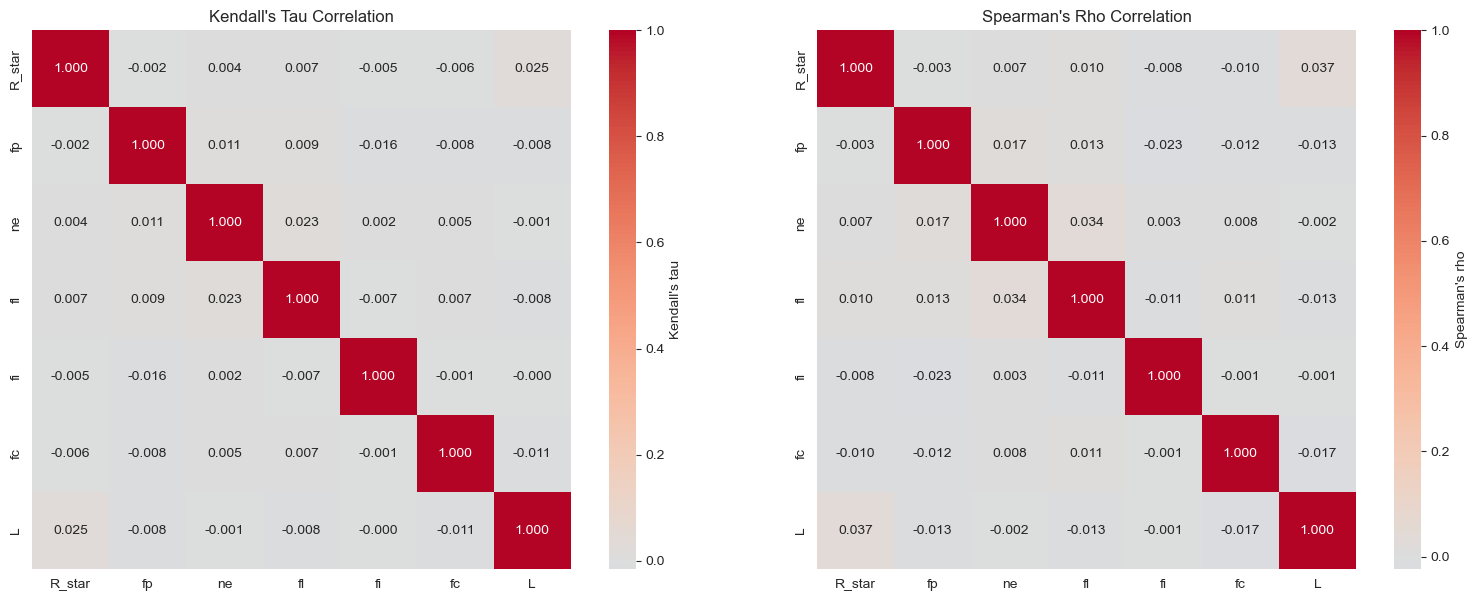

In [20]:
# ============================================================================
# CELL 3: ANALYZE DEPENDENCIES
# ============================================================================

# Select parameters for dependency analysis
params = ['R_star', 'fp', 'ne', 'fl', 'fi', 'fc', 'L']

# Calculate Kendall's tau
kendall_matrix = pd.DataFrame(index=params, columns=params, dtype=float)
for i, param1 in enumerate(params):
    for j, param2 in enumerate(params):
        if i == j:
            kendall_matrix.loc[param1, param2] = 1.0
        else:
            tau, _ = kendalltau(df[param1], df[param2])
            kendall_matrix.loc[param1, param2] = tau

# Calculate Spearman's rho
spearman_matrix = pd.DataFrame(index=params, columns=params, dtype=float)
for i, param1 in enumerate(params):
    for j, param2 in enumerate(params):
        if i == j:
            spearman_matrix.loc[param1, param2] = 1.0
        else:
            rho, _ = spearmanr(df[param1], df[param2])
            spearman_matrix.loc[param1, param2] = rho

# Visualize both
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(kendall_matrix.astype(float), annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, ax=axes[0], square=True, cbar_kws={'label': "Kendall's tau"})
axes[0].set_title("Kendall's Tau Correlation")

sns.heatmap(spearman_matrix.astype(float), annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, ax=axes[1], square=True, cbar_kws={'label': "Spearman's rho"})
axes[1].set_title("Spearman's Rho Correlation")

plt.tight_layout()
plt.show()

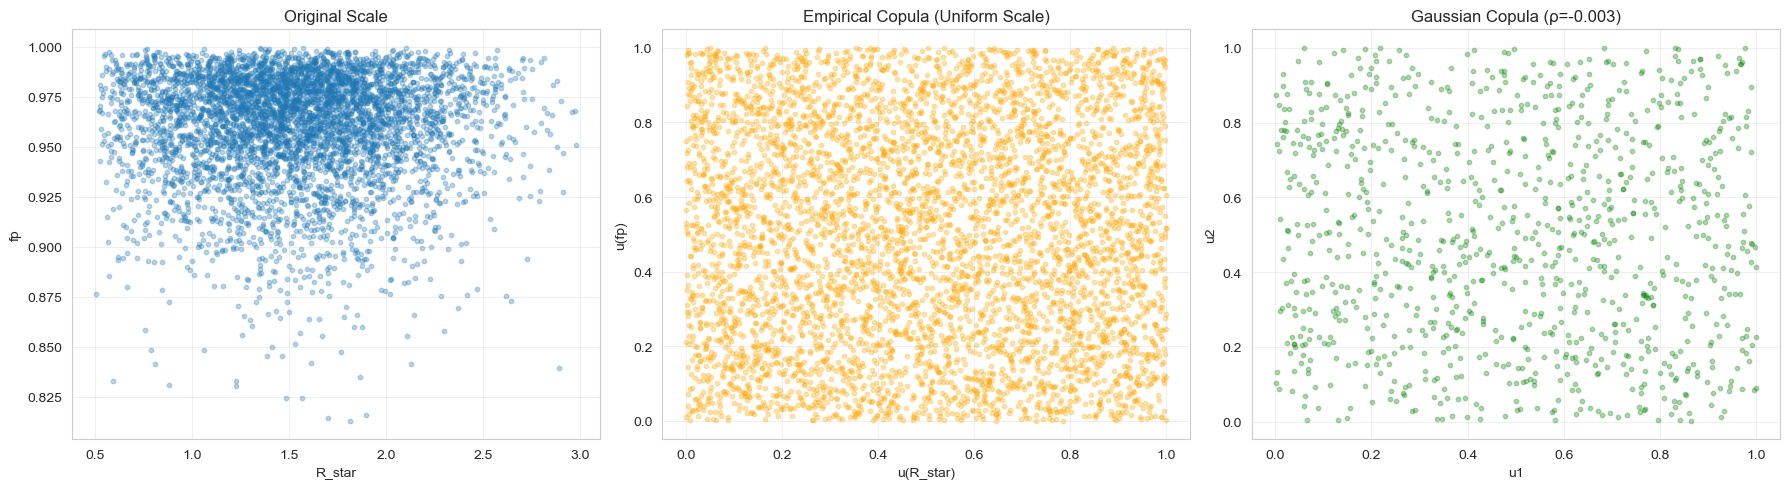

In [22]:
# ============================================================================
# CELL 4: SIMPLE COPULA MODELS
# ============================================================================

def transform_to_uniform(data):
    """Transform data to uniform [0,1] using empirical CDF."""
    n = len(data)
    ranks = stats.rankdata(data)
    return ranks / (n + 1)

def independence_copula(u1, u2, n_samples):
    """Generate samples from independence copula."""
    return np.random.uniform(0, 1, (n_samples, 2))

def gaussian_copula(rho, n_samples):
    """Generate samples from Gaussian copula with correlation rho."""
    mean = [0, 0]
    cov = [[1, rho], [rho, 1]]
    samples = np.random.multivariate_normal(mean, cov, n_samples)
    # Transform to uniform
    u = stats.norm.cdf(samples)
    return u

# Transform observed data to uniform
u_R_star = transform_to_uniform(df['R_star'])
u_fp = transform_to_uniform(df['fp'])

# Scatter plot of transformed data
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original scale
axes[0].scatter(df['R_star'], df['fp'], alpha=0.3, s=10)
axes[0].set_xlabel('R_star')
axes[0].set_ylabel('fp')
axes[0].set_title('Original Scale')
axes[0].grid(True, alpha=0.3)

# Uniform scale (empirical copula)
axes[1].scatter(u_R_star, u_fp, alpha=0.3, s=10, color='orange')
axes[1].set_xlabel('u(R_star)')
axes[1].set_ylabel('u(fp)')
axes[1].set_title('Empirical Copula (Uniform Scale)')
axes[1].grid(True, alpha=0.3)

# Gaussian copula simulation
rho_est, _ = spearmanr(df['R_star'], df['fp'])
u_gauss = gaussian_copula(rho_est, n_samples=1000)
axes[2].scatter(u_gauss[:, 0], u_gauss[:, 1], alpha=0.3, s=10, color='green')
axes[2].set_xlabel('u1')
axes[2].set_ylabel('u2')
axes[2].set_title(f'Gaussian Copula (ρ={rho_est:.3f})')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\rfull\AppData\Local\Temp\ipykernel_20420\1646401329.py:14: RuntimeWarning: invalid value encountered in log
  w = -1/theta * np.log(1 + v * (np.exp(-theta) - 1) /


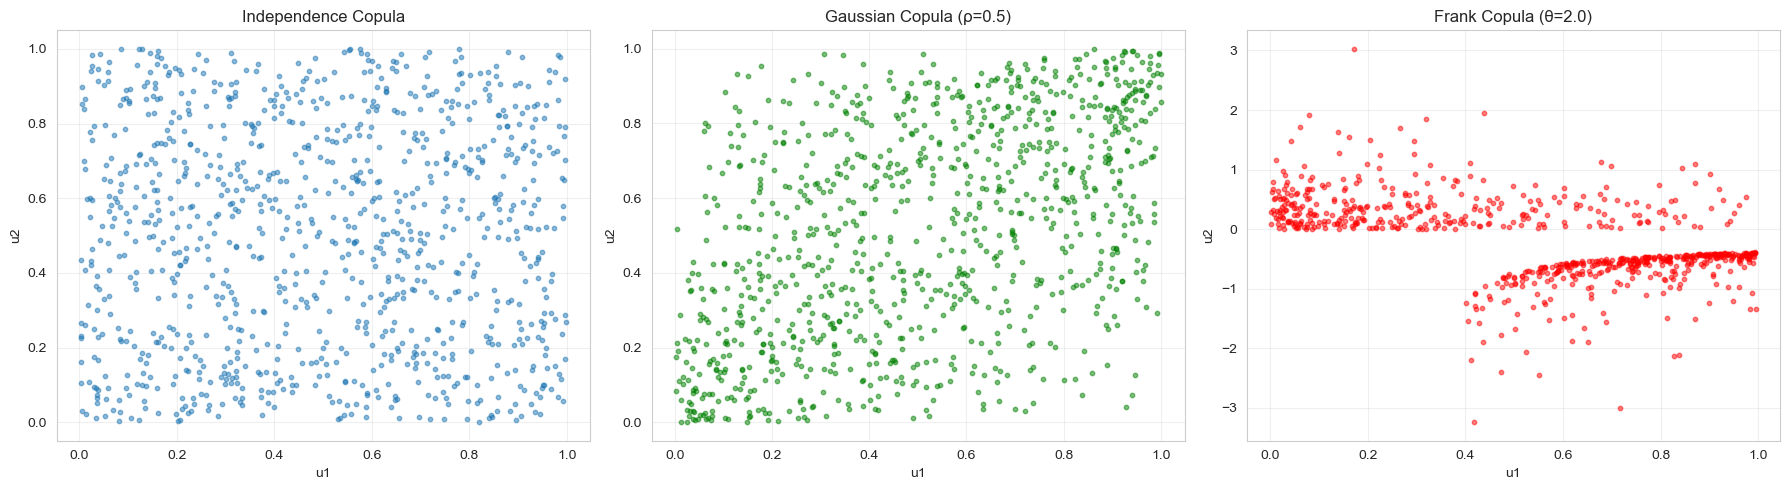

In [24]:
# ============================================================================
# CELL 5: COMPARE DIFFERENT COPULA FAMILIES
# ============================================================================

def frank_copula(theta, n_samples):
    """Simple Frank copula generator."""
    u = np.random.uniform(0, 1, n_samples)
    v = np.random.uniform(0, 1, n_samples)
    
    if abs(theta) < 1e-10:
        return np.column_stack([u, v])
    
    # Frank copula conditional sampling
    w = -1/theta * np.log(1 + v * (np.exp(-theta) - 1) / 
                           (v * (np.exp(-theta * u) - 1) + np.exp(-theta * u)))
    return np.column_stack([u, w])

# Generate samples from different copulas
n_samples = 1000
theta_frank = 2.0  # Moderate positive dependence

# Independence
u_indep = independence_copula(None, None, n_samples)

# Gaussian
u_gauss = gaussian_copula(rho=0.5, n_samples=n_samples)

# Frank
u_frank = frank_copula(theta=theta_frank, n_samples=n_samples)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(u_indep[:, 0], u_indep[:, 1], alpha=0.5, s=10)
axes[0].set_title('Independence Copula')
axes[0].set_xlabel('u1')
axes[0].set_ylabel('u2')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(u_gauss[:, 0], u_gauss[:, 1], alpha=0.5, s=10, color='green')
axes[1].set_title('Gaussian Copula (ρ=0.5)')
axes[1].set_xlabel('u1')
axes[1].set_ylabel('u2')
axes[1].grid(True, alpha=0.3)

axes[2].scatter(u_frank[:, 0], u_frank[:, 1], alpha=0.5, s=10, color='red')
axes[2].set_title(f'Frank Copula (θ={theta_frank})')
axes[2].set_xlabel('u1')
axes[2].set_ylabel('u2')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

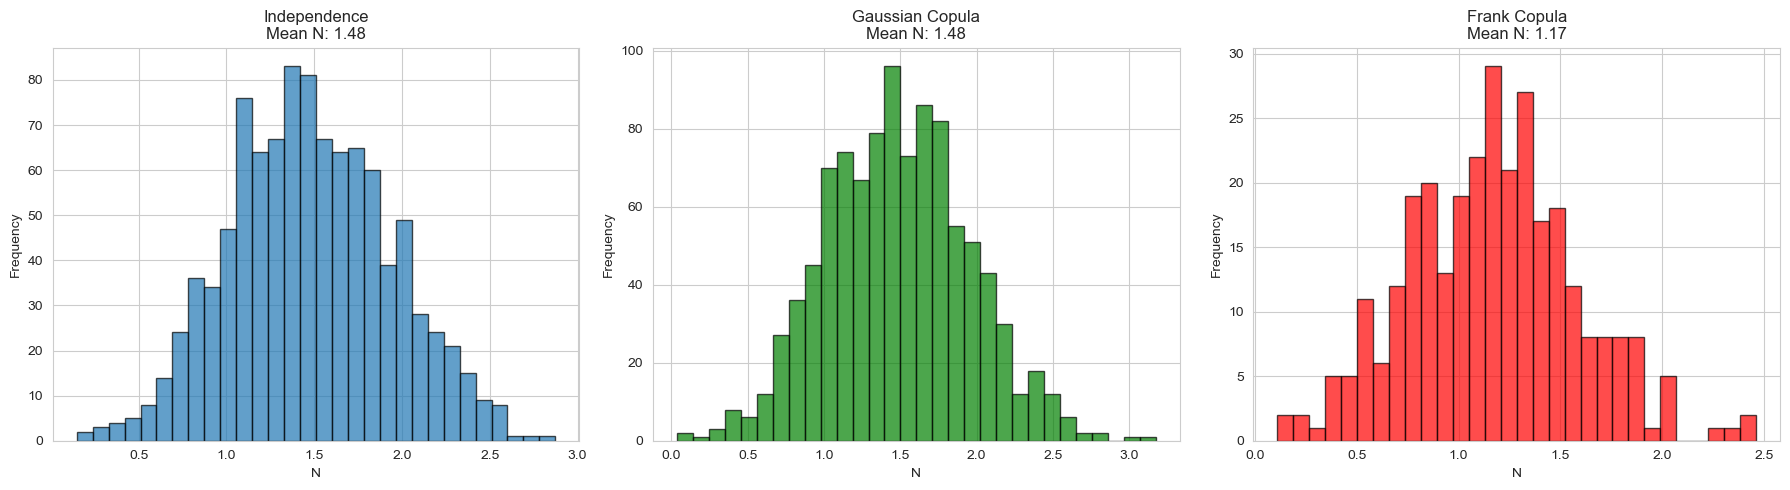


Comparison of N statistics:
Independence: Mean=1.48, Std=0.46
Gaussian:     Mean=1.48, Std=0.47
Frank:        Mean=1.17, Std=0.41


In [14]:
# ============================================================================
# CELL 6: IMPACT ON DRAKE EQUATION
# ============================================================================

def simulate_with_copula(marginals, copula_samples):
    """
    Transform copula samples back to original marginal distributions.
    
    marginals: dict of {param_name: scipy.stats distribution}
    copula_samples: array of uniform [0,1] samples
    """
    results = {}
    param_names = list(marginals.keys())
    
    for idx, param in enumerate(param_names):
        if idx < copula_samples.shape[1]:
            # Transform uniform to original distribution via inverse CDF
            results[param] = marginals[param].ppf(copula_samples[:, idx])
    
    # Calculate N
    N = np.ones(len(copula_samples))
    for param in param_names:
        N *= results[param]
    results['N'] = N
    
    return pd.DataFrame(results)

# Define marginal distributions (approximate from baseline)
marginals = {
    'R_star': stats.norm(loc=df['R_star'].mean(), scale=df['R_star'].std()),
    'fp': stats.beta(a=50, b=2),
}

# Simulate with different copulas
df_indep = simulate_with_copula(marginals, u_indep)
df_gauss = simulate_with_copula(marginals, u_gauss)
df_frank = simulate_with_copula(marginals, u_frank)

# Compare N distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(df_indep['N'], bins=30, alpha=0.7, edgecolor='black')
axes[0].set_title(f'Independence\nMean N: {df_indep["N"].mean():.2f}')
axes[0].set_xlabel('N')
axes[0].set_ylabel('Frequency')

axes[1].hist(df_gauss['N'], bins=30, alpha=0.7, edgecolor='black', color='green')
axes[1].set_title(f'Gaussian Copula\nMean N: {df_gauss["N"].mean():.2f}')
axes[1].set_xlabel('N')
axes[1].set_ylabel('Frequency')

axes[2].hist(df_frank['N'], bins=30, alpha=0.7, edgecolor='black', color='red')
axes[2].set_title(f'Frank Copula\nMean N: {df_frank["N"].mean():.2f}')
axes[2].set_xlabel('N')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nComparison of N statistics:")
print("="*60)
print(f"Independence: Mean={df_indep['N'].mean():.2f}, Std={df_indep['N'].std():.2f}")
print(f"Gaussian:     Mean={df_gauss['N'].mean():.2f}, Std={df_gauss['N'].std():.2f}")
print(f"Frank:        Mean={df_frank['N'].mean():.2f}, Std={df_frank['N'].std():.2f}")

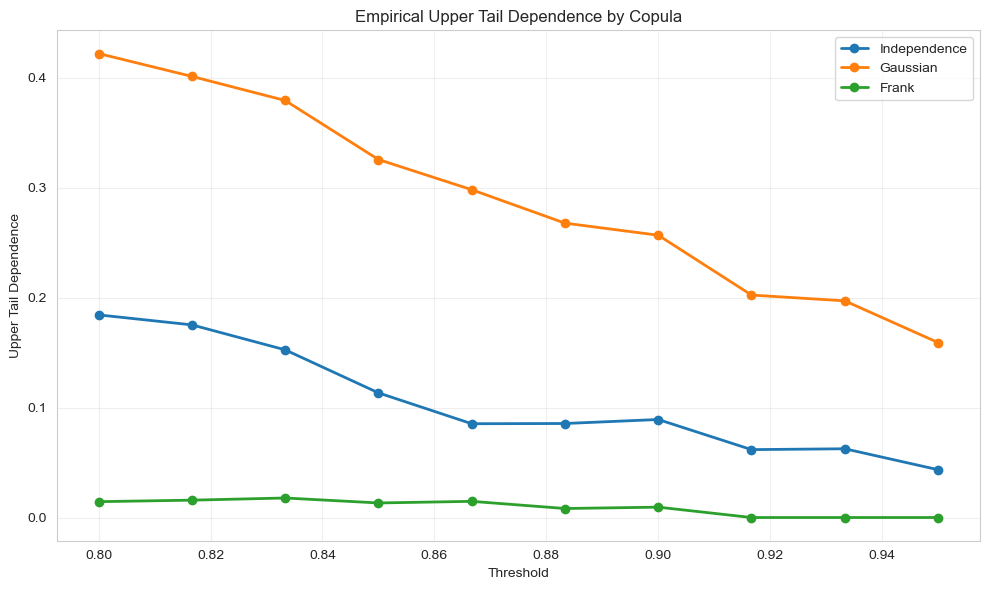

In [26]:
# ============================================================================
# CELL 7: TAIL DEPENDENCY ANALYSIS
# ============================================================================

def empirical_tail_dependence(u, v, threshold=0.9):
    """Calculate empirical upper tail dependence."""
    mask = (u > threshold) & (v > threshold)
    n_upper = np.sum(mask)
    n_total = np.sum(u > threshold)
    return n_upper / n_total if n_total > 0 else 0

# Calculate tail dependencies
thresholds = np.linspace(0.8, 0.95, 10)
tail_deps = {'Independence': [], 'Gaussian': [], 'Frank': []}

for thresh in thresholds:
    tail_deps['Independence'].append(
        empirical_tail_dependence(u_indep[:, 0], u_indep[:, 1], thresh)
    )
    tail_deps['Gaussian'].append(
        empirical_tail_dependence(u_gauss[:, 0], u_gauss[:, 1], thresh)
    )
    tail_deps['Frank'].append(
        empirical_tail_dependence(u_frank[:, 0], u_frank[:, 1], thresh)
    )

# Plot
plt.figure(figsize=(10, 6))
for copula_name, deps in tail_deps.items():
    plt.plot(thresholds, deps, marker='o', label=copula_name, linewidth=2)

plt.xlabel('Threshold')
plt.ylabel('Upper Tail Dependence')
plt.title('Empirical Upper Tail Dependence by Copula')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()